In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
customer = pd.read_csv('Part A/customer_data.csv')
customer.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
0,1,Male,19,15,39,1.054960,0.036968,1
1,2,Male,21,15,81,0.676210,0.119785,1
2,3,Female,20,16,6,0.562232,0.010672,1
3,4,Female,23,16,77,1.284359,0.059952,1
4,5,Female,31,17,40,0.806683,0.049586,1


In [3]:
customer.describe()


,CustomerID,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,38.850000,60.560000,50.200000,4.538022,0.015816,2.50000
std,57.879185,13.969007,26.264721,25.823522,2.214437,0.017091,1.12084
min,1.000000,18.000000,15.000000,1.000000,0.562232,0.000157,1.00000
25%,50.750000,28.750000,41.500000,34.750000,2.963534,0.008362,1.75000
50%,100.500000,36.000000,61.500000,50.000000,4.577495,0.012212,2.50000
75%,150.250000,49.000000,78.000000,73.000000,5.905840,0.015903,3.25000
max,200.000000,70.000000,137.000000,99.000000,11.133367,0.119785,4.00000


In [4]:
customer.isna().sum()

CustomerID                 0
Gender                     0
Age                        0
Income (k$)                0
How Much They Spend ($)    0
Salary (k$)                0
Spend to income ratio      0
Alpha                      0
dtype: int64

# EDA

In [5]:
customer.columns.tolist()

['CustomerID',
 'Gender',
 'Age',
 'Income (k$)',
 'How Much They Spend ($)',
 'Salary (k$)',
 'Spend to income ratio',
 'Alpha']

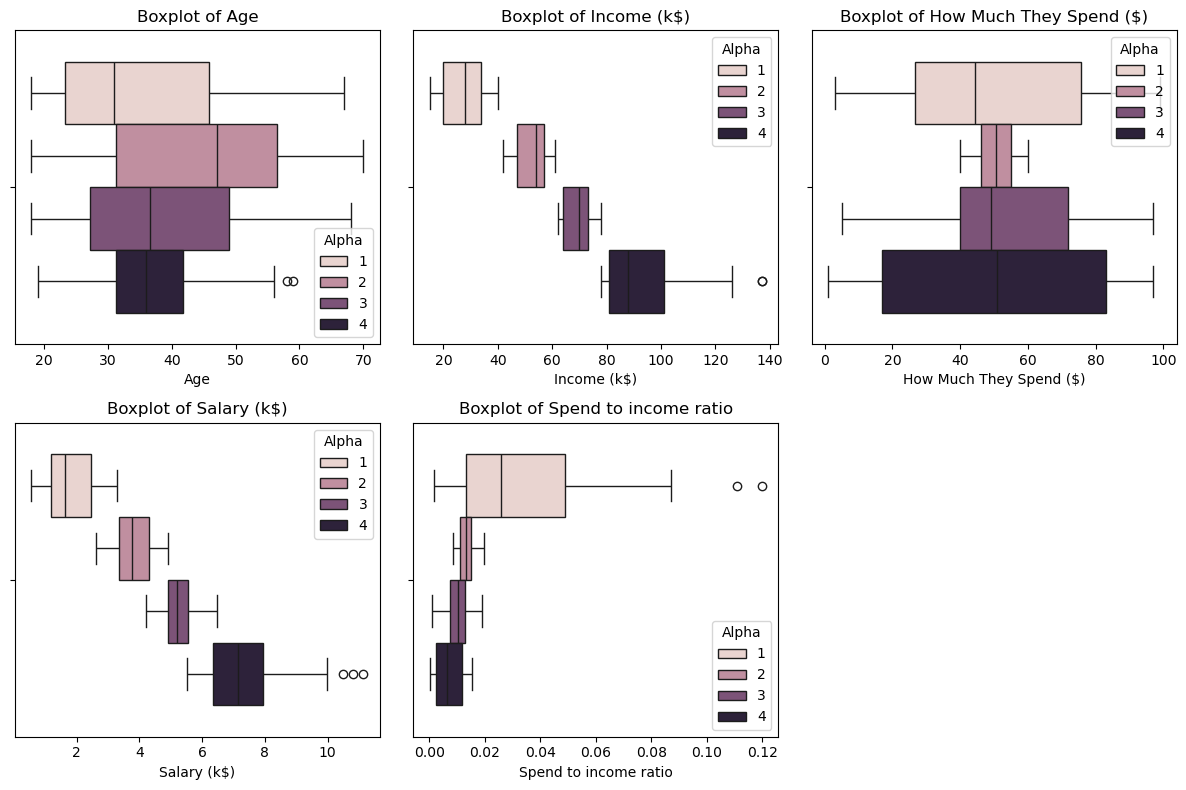

In [6]:
# Plotting the numerical features to visualize outliers
numerical_cols = ["Age", "Income (k$)", "How Much They Spend ($)", "Salary (k$)", "Spend to income ratio"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data = customer, x = col, hue="Alpha")
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

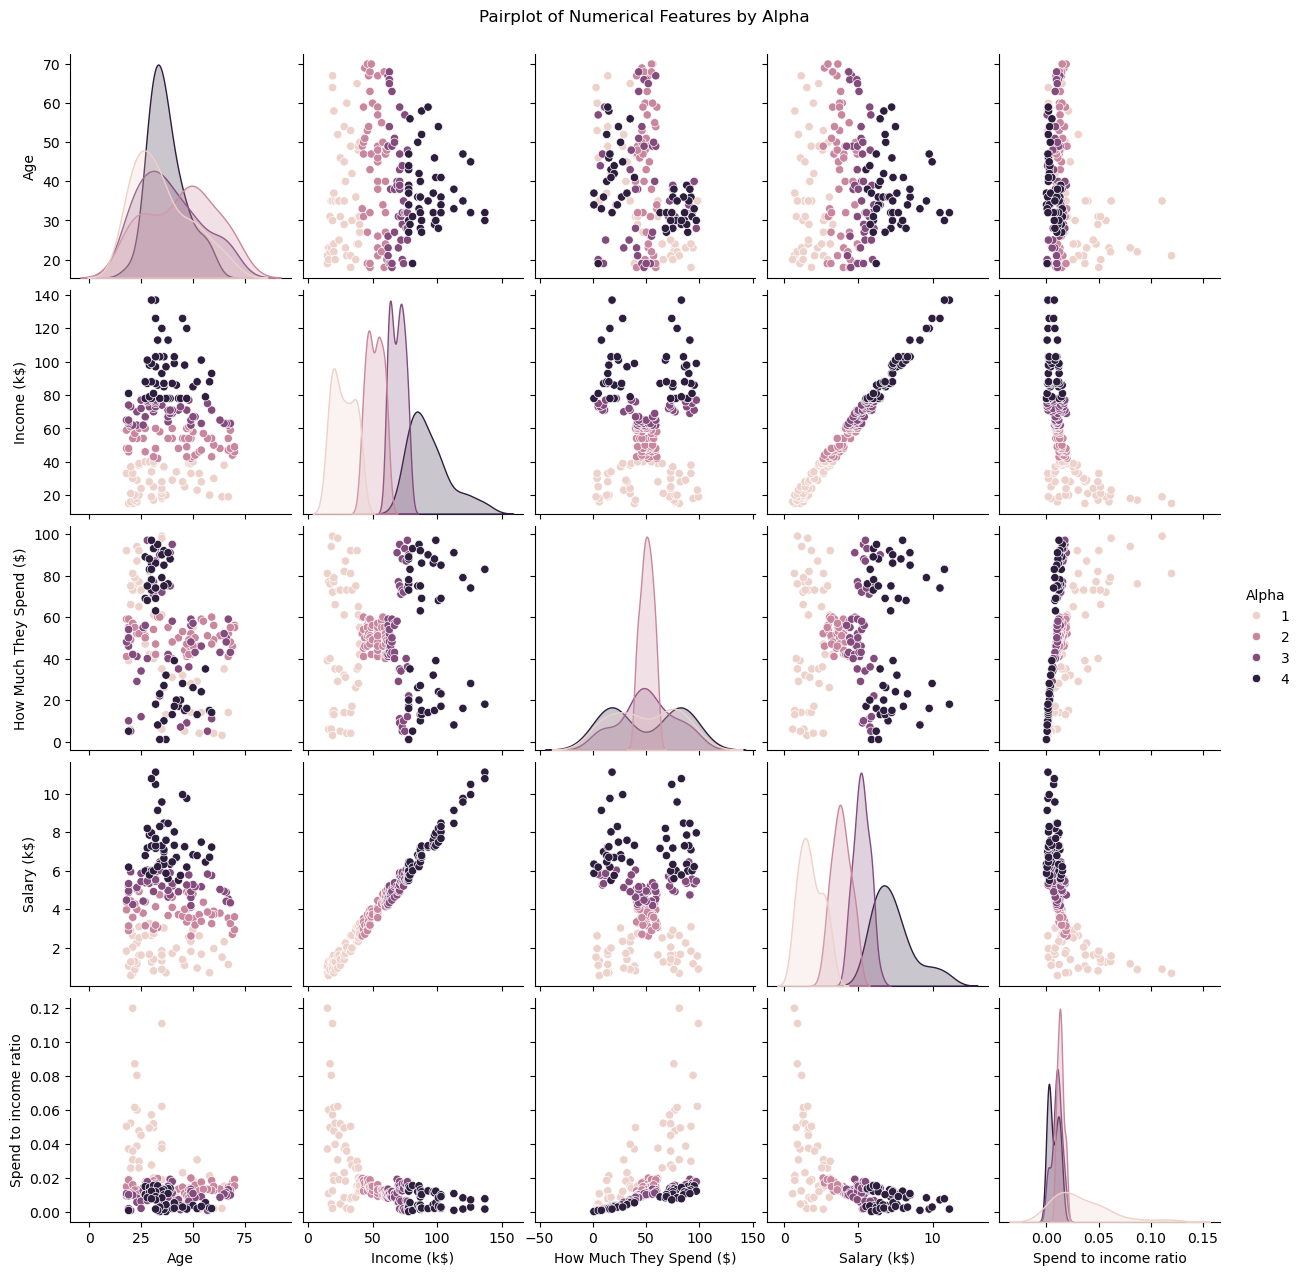

In [7]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Alpha', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Alpha', y=1.02)
plt.show()

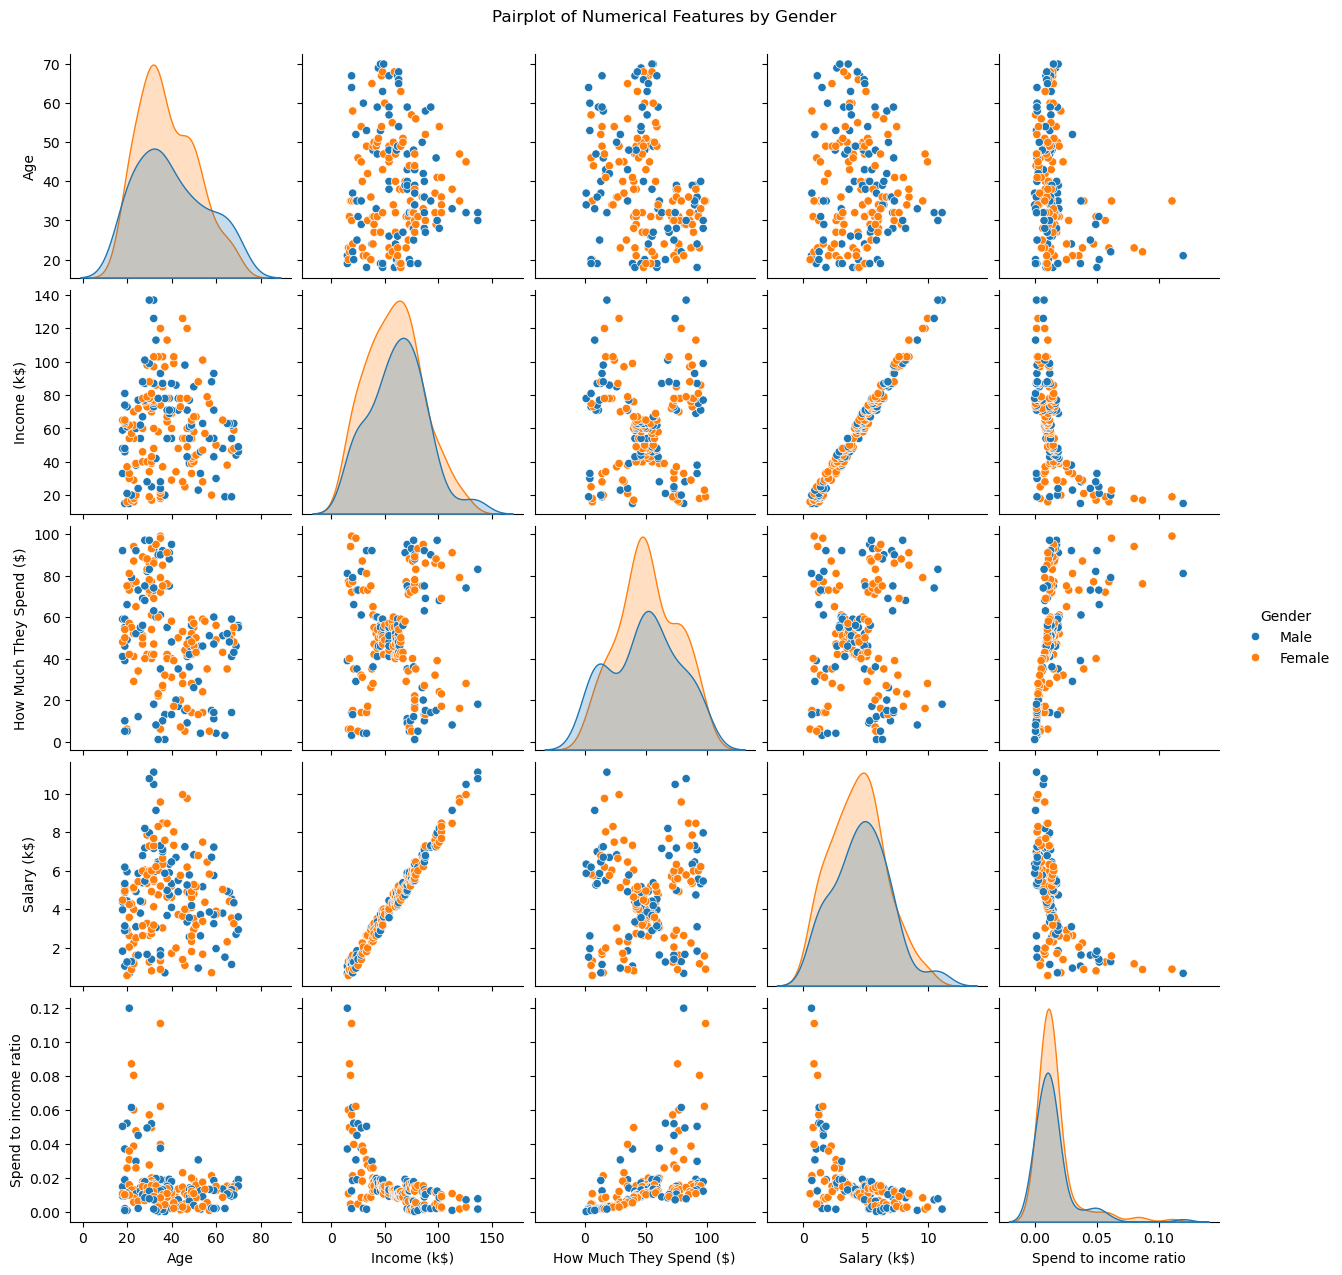

In [8]:
# pair plot to visualize relationships between numerical features
g = sns.pairplot(customer, hue='Gender', vars=numerical_cols)
g.figure.suptitle('Pairplot of Numerical Features by Gender', y=1.02)
plt.show()

# Data transformation

Transform the numerical features using StandardScaler to have 0 means and 1 variance

In [9]:
# Data Preprocessing
# copy the original DataFrame to avoid modifying it directly
customer_transform = customer.copy()
# remove unnecessary columns  
customer_transform.drop(columns=['CustomerID'], inplace=True)

# Transform numerical columns with StandardScaler
scaler = StandardScaler()
numerical_cols = customer_transform.select_dtypes(include=['int64', 'float64']).columns
customer_transform[numerical_cols] = scaler.fit_transform(customer_transform[numerical_cols]) 
# Transform categorical columns with one-hot encoding
categorical_cols = ["Gender"]
customer_transform = pd.get_dummies(customer_transform, columns=categorical_cols, drop_first=True, dtype=int)

print(customer_transform.head())
print("\nDescriptive statistics of transformed data:")
print(customer_transform.describe())


        Age  Income (k$)  How Much They Spend ($)  Salary (k$)  \
0 -1.424569    -1.738999                -0.434801    -1.576835   
1 -1.281035    -1.738999                 1.195704    -1.748301   
2 -1.352802    -1.700830                -1.715913    -1.799901   
3 -1.137502    -1.700830                 1.040418    -1.472983   
4 -0.563369    -1.662660                -0.395980    -1.689234   

   Spend to income ratio     Alpha  Gender_Male  
0               1.240737 -1.341641            1  
1               6.098642 -1.341641            1  
2              -0.301771 -1.341641            0  
3               2.588929 -1.341641            0  
4               1.980859 -1.341641            0  

Descriptive statistics of transformed data:
                Age   Income (k$)  How Much They Spend ($)   Salary (k$)  \
count  2.000000e+02  2.000000e+02             2.000000e+02  2.000000e+02   
mean  -1.021405e-16 -2.131628e-16            -1.465494e-16 -7.105427e-17   
std    1.002509e+00  1.002509e

# choosing n_clusters using the elbow method

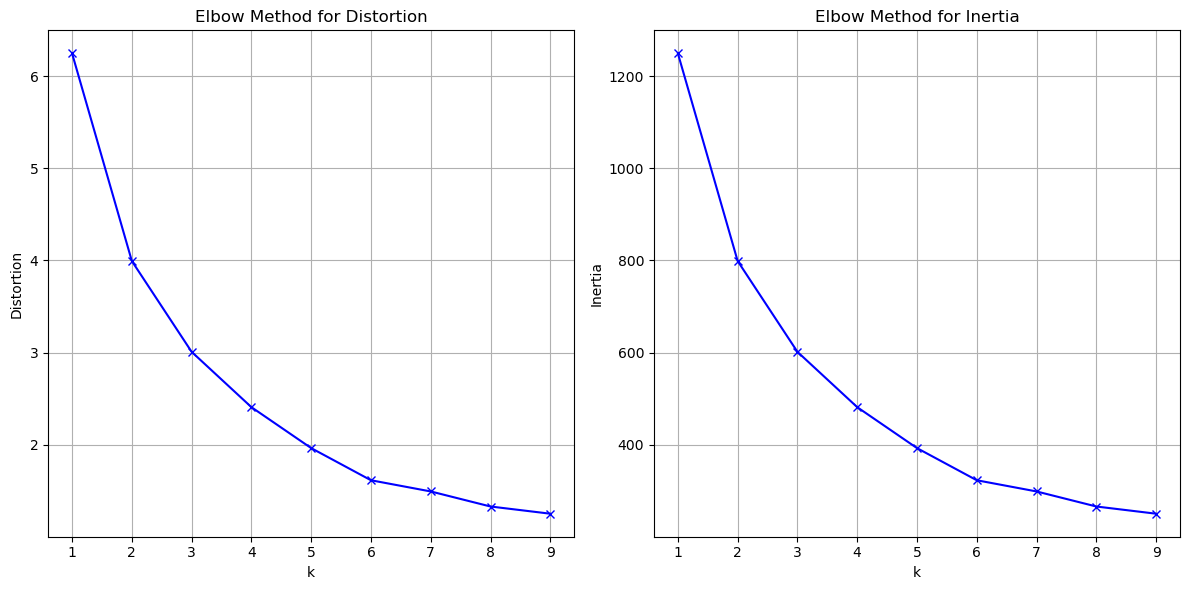

Distortion values:
1 : 6.246399999999999
2 : 3.993974002250099
3 : 3.0090533557254746
4 : 2.409006059069258
5 : 1.9649443127869315
6 : 1.6161449638524197
7 : 1.49473200100746
8 : 1.3314350833592774
9 : 1.253302051426047

Inertia values:
1 : 1249.28
2 : 798.7948004500197
3 : 601.810671145095
4 : 481.80121181385147
5 : 392.98886255738626
6 : 323.2289927704836
7 : 298.9464002014919
8 : 266.28701667185555
9 : 250.6604102852094


In [10]:
# Using Elbow method to choose n_cluster

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(customer_transform)
    distortions.append(sum(np.min(cdist(customer_transform, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / customer_transform.shape[0])
    inertias.append(kmeanModel.inertia_)
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

# Plotting the elbow curve for distortions and inertias
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Distortion')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Inertia')
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')

print()
print("Inertia values:")
for key, val in mapping2.items():
    print(f'{key} : {val}')

# choosing n_clusters using silhouette scores

Silhouette Score Analysis:
----------------------------------------
k= 2: Silhouette Score = 0.3088
k= 3: Silhouette Score = 0.3089
k= 4: Silhouette Score = 0.3335
k= 5: Silhouette Score = 0.3274
k= 6: Silhouette Score = 0.3505
k= 7: Silhouette Score = 0.3274
k= 8: Silhouette Score = 0.3221
k= 9: Silhouette Score = 0.2974
k=10: Silhouette Score = 0.2820

Optimal k based on Silhouette Score: 6 (Score: 0.3505)


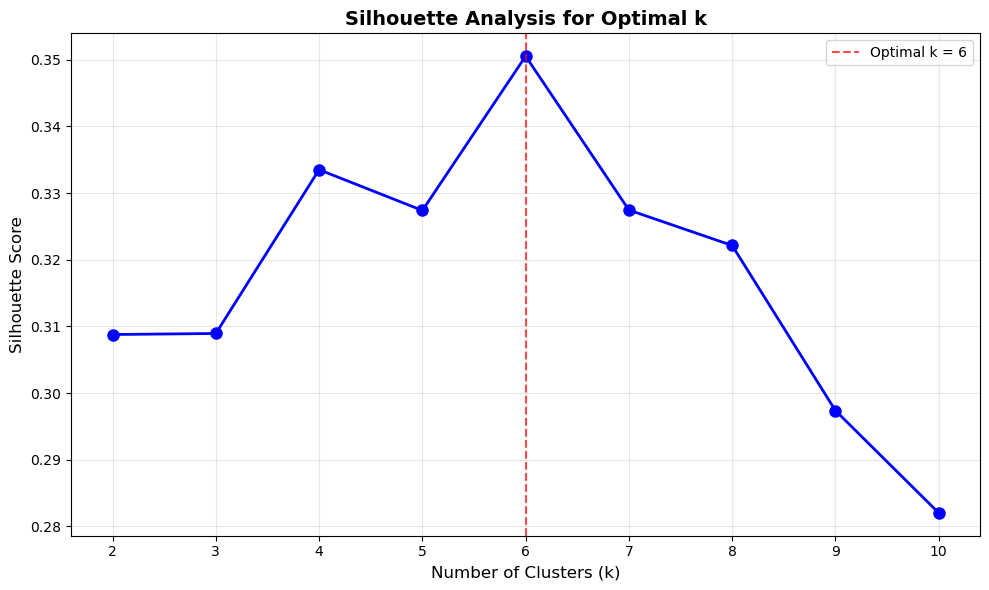

In [11]:
# Calculate silhouette scores for different k values
silhouette_scores = []
k_silhouette_mapping = {}

print("Silhouette Score Analysis:")
print("-" * 40)

for k in range(2, 11):
    # Fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    cluster_labels = kmeans.fit_predict(customer_transform)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(customer_transform, cluster_labels, metric="euclidean")
    
    # Store results
    silhouette_scores.append(silhouette_avg)
    k_silhouette_mapping[k] = silhouette_avg
    
    print(f"k={k:2d}: Silhouette Score = {silhouette_avg:.4f}")

# Find optimal k based on silhouette score
optimal_k = max(k_silhouette_mapping, key=k_silhouette_mapping.get)
print(f"\nOptimal k based on Silhouette Score: {optimal_k} (Score: {k_silhouette_mapping[optimal_k]:.4f})")

# Plotting silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(range(2, 11))

# Highlight optimal k
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k = {optimal_k}')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# Anomaly

KMeans(n_clusters=6)


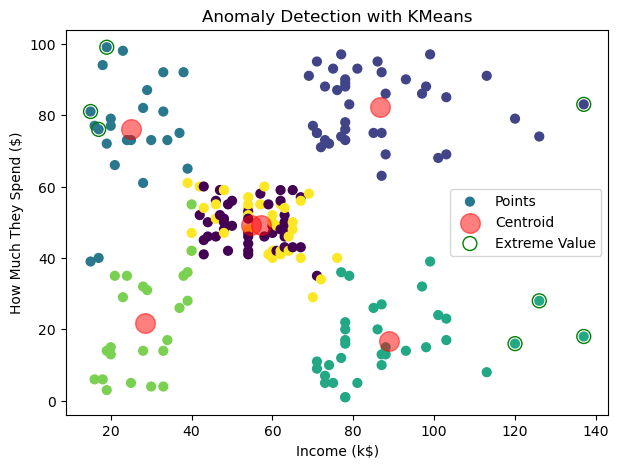

Anomalies from the original data:
     CustomerID  Gender  Age  Income (k$)  How Much They Spend ($)  \
1             2    Male   21           15                       81   
5             6  Female   22           17                       76   
11           12  Female   35           19                       99   
194         195  Female   47          120                       16   
196         197  Female   45          126                       28   
198         199    Male   32          137                       18   
199         200    Male   30          137                       83   

     Salary (k$)  Spend to income ratio  Alpha  
1       0.676210               0.119785      1  
5       0.873059               0.087050      1  
11      0.893771               0.110767      1  
194     9.770024               0.001638      4  
196     9.966931               0.002809      4  
198    11.133367               0.001617      4  
199    10.796760               0.007687      4  


In [12]:
def anomalies_idx(cluster, distances, n_anomalies = 5):
  idx = []
  for i in range(cluster):
    idx.append(np.argsort(distances[:,i].ravel())[::-1][:n_anomalies])
  idx = np.array(idx)
  # flatten the idx array and remove duplicates
  idx = np.unique(idx.flatten())
  return idx

# Anomaly Detection using KMeans
cluster = 6

kmeans = KMeans(n_clusters=cluster)
kmeans.fit(customer_transform)
print(kmeans)
y_kmeans = kmeans.predict(customer_transform)
centers = kmeans.cluster_centers_
centers_inv = scaler.inverse_transform(centers[:,:-1]) 

# Visualize the results

'''
# scatter plot the data points
f, ax = plt.subplots(figsize=(7, 5))
ax.scatter(customer["Income (k$)"], customer["How Much They Spend ($)"], c=y_kmeans, s=50, cmap='viridis',label='Points')
# show centroid centres as red circle opacity 50%
ax.scatter(centers_inv[:, 1], centers_inv[:, 2], label='Centroid', color='r', s=200, alpha=0.5)
ax.legend()
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend ($)")
plt.show()
'''


# argsort returns an array of indexes which will sort the array in
# ascending order
# so we reverse it via [::-1] and take the top five with [:5]
distances = kmeans.transform(customer_transform)
sorted_idx = anomalies_idx(cluster, distances, n_anomalies = 3)
# Now let's see which are the top n_anomalies points furthest away
f, ax = plt.subplots(figsize=(7, 5))
ax.set_title("Anomaly Detection with KMeans")
ax.scatter(customer["Income (k$)"], customer["How Much They Spend ($)"], c=y_kmeans, s=40, cmap='viridis',label='Points')
ax.scatter(centers_inv[:, 1], centers_inv[:, 2], label='Centroid', color='r', s=200, alpha=0.5)
ax.scatter(customer.iloc[sorted_idx]['Income (k$)'], 
           customer.iloc[sorted_idx]["How Much They Spend ($)"], 
           label='Extreme Value', edgecolors='g', facecolors='none', s=100)
ax.legend(loc='best')
plt.xlabel("Income (k$)")
plt.ylabel("How Much They Spend ($)")
plt.show()
# It's easy to remove these points if we like:
# new_Customer = np.delete(customer_transform, sorted_idx, axis=0)
new_Customer_transformed = customer_transform.drop(customer_transform.index[sorted_idx])
new_Customer = customer_transform.drop(customer.index[sorted_idx])
# Or to extract the anomalies
anomaly = customer.iloc[sorted_idx]
anomaly_transformed = customer_transform.iloc[sorted_idx]
print("Anomalies from the original data:")
print(anomaly)

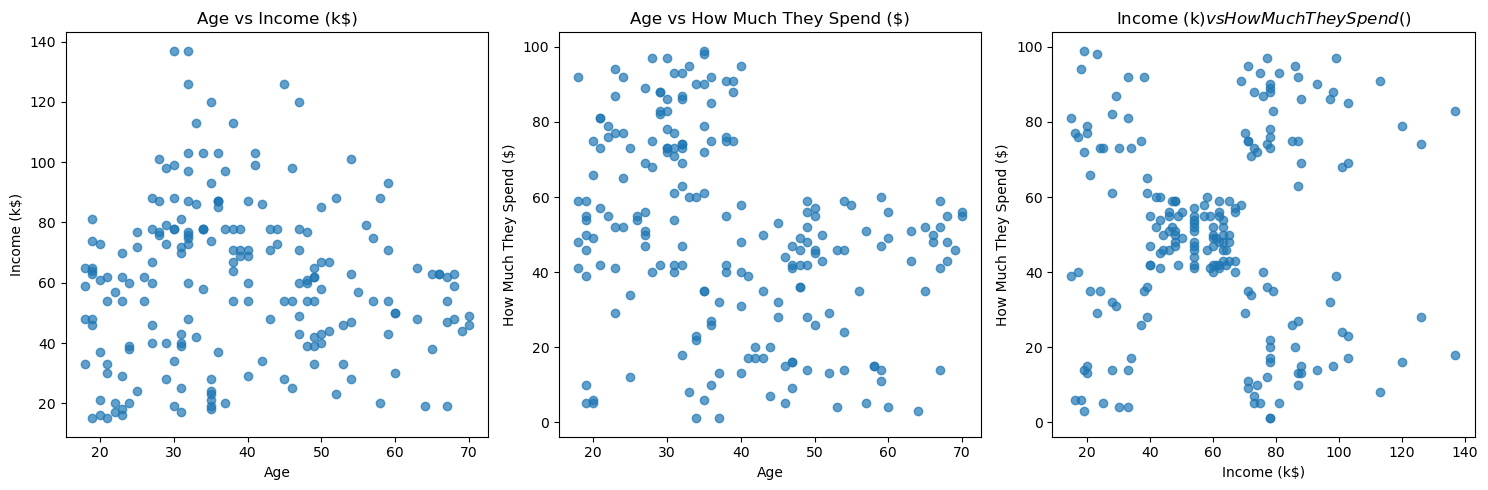

In [13]:
def plot_feature_pairs(df, feature_pairs, max_cols=3, figsize=(15, 5)):
  """
  Plots scatter plots for a list of feature pairs in subplots.

  Parameters:
  - df: pandas DataFrame containing the data.
  - feature_pairs: list of tuples, each tuple contains two feature names (x, y).
  - max_cols: maximum number of columns in the subplot grid.
  - figsize: size of the entire figure.
  """
  n_pairs = len(feature_pairs)
  n_cols = min(max_cols, n_pairs)
  n_rows = (n_pairs + n_cols - 1) // n_cols

  fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
  axes = np.array(axes).reshape(-1)  # Flatten in case of single row/col

  for idx, (x, y) in enumerate(feature_pairs):
    ax = axes[idx]
    ax.scatter(df[x], df[y], alpha=0.7)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'{x} vs {y}')

  # Hide unused subplots
  for j in range(idx + 1, n_rows * n_cols):
    axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()

# Example usage:
feature_pairs = [
  ("Age", "Income (k$)"),
  ("Age", "How Much They Spend ($)"),
  ("Income (k$)", "How Much They Spend ($)")
]
plot_feature_pairs(customer, feature_pairs)

# PCA

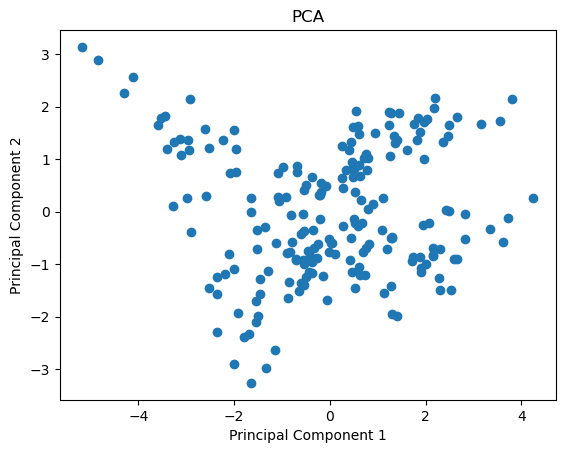

In [14]:
# Apply PCA with two components (for 2D visualization)
pca = PCA(n_components=2)
pca = pca.fit_transform(customer_transform)
# Plot the results
plt.scatter(pca[:, 0], pca[:, 1])
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [15]:
numerical_cols

Index(['Age', 'Income (k$)', 'How Much They Spend ($)', 'Salary (k$)',
       'Spend to income ratio', 'Alpha'],
      dtype='object')

In [16]:
customer_transform

,Age,Income (k$),How Much They Spend ($),Salary (k$),Spend to income ratio,Alpha,Gender_Male
0,-1.424569,-1.738999,-0.434801,-1.576835,1.240737,-1.341641,1
1,-1.281035,-1.738999,1.195704,-1.748301,6.098642,-1.341641,1
2,-1.352802,-1.700830,-1.715913,-1.799901,-0.301771,-1.341641,0
3,-1.137502,-1.700830,1.040418,-1.472983,2.588929,-1.341641,0
4,-0.563369,-1.662660,-0.395980,-1.689234,1.980859,-1.341641,0
...,...,...,...,...,...,...,...
195,-0.276302,2.268791,1.118061,2.283437,-0.444136,1.341641,0
196,0.441365,2.497807,-0.861839,2.457749,-0.762969,1.341641,0
197,-0.491602,2.497807,0.923953,2.697978,-0.514260,1.341641,1
198,-0.491602,2.917671,-1.250054,2.985813,-0.832921,1.341641,1


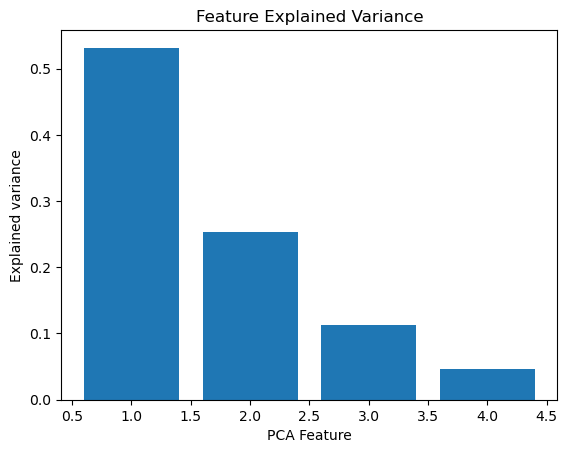

In [17]:
# where this iris dataset has four features.
pca = PCA(n_components=4)
# Fit and transform data
pca_features = pca.fit_transform(customer_transform)
# Bar plot of explained_variance_ratio_
plt.bar(range(1,len(pca.explained_variance_ratio_)+1),
pca.explained_variance_ratio_)
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

# Set up the imports for 3-d plotting.
from mpl_toolkits import mplot3d



fig = plt.figure()
ax = plt.axes(projection='3d')

# Apply PCA with three components (for 3d visualization)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(customer_transform)
# Plot the results in 3d.
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
plt.title('PCA of Iris Dataset')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [20]:
from mpl_toolkits import mplot3d

# Magic line to make your 3-d graph pop out,
# and you can interactively rotate it.
%matplotlib tk

# Visualize PCA-based clustering
def visualize_pca_clustering(data, n_components=3, n_clusters=6):
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(data)
    
    # Apply KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_pca)
    
    if n_components == 2:
        # 2D visualization
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                   c='red', marker='x', s=200, alpha=0.8, label='Centroids')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.title(f'KMeans Clustering on PCA-reduced Data ({n_components}D)')
        plt.colorbar(scatter)
        plt.legend()
        plt.show()
        
    elif n_components == 3:
        # 3D visualization
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                           c=clusters, cmap='viridis', alpha=0.7)
        ax.scatter(kmeans.cluster_centers_[:, 0], 
                  kmeans.cluster_centers_[:, 1], 
                  kmeans.cluster_centers_[:, 2],
                  c='red', marker='x', s=200, alpha=0.8)
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
        ax.set_title(f'KMeans Clustering on PCA-reduced Data ({n_components}D)')
        plt.colorbar(scatter)
        plt.show()

# Visualize different PCA dimensions
visualize_pca_clustering(customer_transform, n_components=2)
visualize_pca_clustering(customer_transform, n_components=3)

In [21]:
# Compare clustering with and without PCA
def compare_clustering_performance(data, n_clusters=6):
    results = {}
    
    # Original data clustering
    kmeans_original = KMeans(n_clusters=n_clusters, random_state=42)
    clusters_original = kmeans_original.fit_predict(data)
    silhouette_original = silhouette_score(data, clusters_original)
    
    # PCA + clustering for different components
    for n_comp in [2, 3, 4, 5]:
        pca = PCA(n_components=n_comp)
        X_pca = pca.fit_transform(data)
        
        kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
        clusters_pca = kmeans_pca.fit_predict(X_pca)
        silhouette_pca = silhouette_score(X_pca, clusters_pca)
        
        results[f'PCA_{n_comp}'] = {
            'silhouette': silhouette_pca,
            'explained_variance': pca.explained_variance_ratio_.sum(),
            'clusters': clusters_pca,
            'data': X_pca
        }
    
    results['Original'] = {
        'silhouette': silhouette_original,
        'explained_variance': 1.0,
        'clusters': clusters_original,
        'data': data
    }
    
    # Print comparison
    print("Clustering Performance Comparison:")
    print("-" * 50)
    for method, metrics in results.items():
        print(f"{method:12}: Silhouette = {metrics['silhouette']:.4f}, "
              f"Variance = {metrics['explained_variance']:.3f}")
    
    return results

performance_results = compare_clustering_performance(customer_transform)

Clustering Performance Comparison:
--------------------------------------------------
PCA_2       : Silhouette = 0.4056, Variance = 0.785
PCA_3       : Silhouette = 0.4229, Variance = 0.898
PCA_4       : Silhouette = 0.4087, Variance = 0.945
PCA_5       : Silhouette = 0.3683, Variance = 0.983
Original    : Silhouette = 0.3505, Variance = 1.000


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def compare_clustering_with_pipelines(data, n_clusters=6):
    results = {}
    
    # Pipeline 1: KMeans without PCA
    kmeans_pipeline = Pipeline([
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])
    
    # Fit and get clusters
    clusters_no_pca = kmeans_pipeline.fit_predict(data)
    silhouette_no_pca = silhouette_score(data, clusters_no_pca)
    
    results['No_PCA'] = {
        'pipeline': kmeans_pipeline,
        'silhouette': silhouette_no_pca,
        'explained_variance': 1.0,
        'clusters': clusters_no_pca,
        'n_components': data.shape[1]
    }
    
    # Pipeline 2-5: PCA + KMeans for different components
    for n_comp in [2, 3, 4, 5]:
        pca_kmeans_pipeline = Pipeline([
            ('pca', PCA(n_components=n_comp)),
            ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
        ])
        
        # Fit and get clusters
        clusters_pca = pca_kmeans_pipeline.fit_predict(data)
        
        # Get PCA-transformed data for silhouette calculation
        X_pca = pca_kmeans_pipeline.named_steps['pca'].transform(data)
        silhouette_pca = silhouette_score(X_pca, clusters_pca)
        
        # Get explained variance
        explained_var = pca_kmeans_pipeline.named_steps['pca'].explained_variance_ratio_.sum()
        
        results[f'PCA_{n_comp}'] = {
            'pipeline': pca_kmeans_pipeline,
            'silhouette': silhouette_pca,
            'explained_variance': explained_var,
            'clusters': clusters_pca,
            'n_components': n_comp
        }
    
    return results

# Run the comparison
pipeline_results = compare_clustering_with_pipelines(customer_transform)

# Print results
print("Pipeline-Based Clustering Comparison:")
print("=" * 60)
for method, metrics in pipeline_results.items():
    print(f"{method:12}: Silhouette = {metrics['silhouette']:.4f}, "
          f"Variance = {metrics['explained_variance']:.3f}, "
          f"Components = {metrics['n_components']}")

Pipeline-Based Clustering Comparison:
No_PCA      : Silhouette = 0.3505, Variance = 1.000, Components = 7
PCA_2       : Silhouette = 0.4056, Variance = 0.785, Components = 2
PCA_3       : Silhouette = 0.4229, Variance = 0.898, Components = 3
PCA_4       : Silhouette = 0.4087, Variance = 0.945, Components = 4
PCA_5       : Silhouette = 0.3683, Variance = 0.983, Components = 5
